In [1]:
import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt

from jax import vmap, jit
from fastprogress import progress_bar
from tensorflow_probability.substrates import jax as tfp
tfd = tfp.distributions

import bayes_ca.inference as core
from bayes_ca.prox_grad import pgd
from bayes_ca._utils import _safe_handling_params

In [2]:
@jit
def gibbs_sample_subject_means(key,
                         subj_obs, 
                         sigmasq_obs, 
                         global_means, 
                         sigmasq_subj, 
                         mu_pri, 
                         sigmasq_pri, 
                         hazard_rates):
    num_subjects = subj_obs.shape[0]
    effective_sigmasq = 1 / (1 / sigmasq_obs + 1 / sigmasq_subj)
    effective_emissions = effective_sigmasq * (subj_obs / sigmasq_obs + global_means / sigmasq_subj)

    _sample_one = lambda key, y: core.gaussian_cp_posterior_sample(
        key, y, hazard_rates, mu_pri, sigmasq_pri, effective_sigmasq)[1]
    return vmap(_sample_one)(jr.split(key, num_subjects), effective_emissions)

In [3]:
# @jit
def step(key,
         subj_obs, 
         sigmasq_obs, 
         global_means, 
         sigmasq_subj, 
         mu_pri, 
         sigmasq_pri, 
         hazard_rates):
    
    # Sample new subject means
    subj_means = gibbs_sample_subject_means(
        key, subj_obs, sigmasq_obs, global_means, sigmasq_subj, mu_pri, sigmasq_pri, hazard_rates)
    
    # Update the global mean
    result = pgd(global_means, subj_means, mu_pri, sigmasq_pri, sigmasq_subj, hazard_rates)
    global_means = result.x

    joint_lp = core.joint_lp(global_means, subj_means, subj_obs, mu_pri, sigmasq_pri, sigmasq_subj, sigmasq_obs, hazard_rates)
    
    return global_means, subj_means, joint_lp

# Simulation 1. Single, staggered changepoint for two subjects

In [4]:
key = jr.PRNGKey(0)

# data settings
num_subjects = 2
num_features = 1
num_timesteps = 300

mu_pri = 0.0
sigmasq_pri = 3.0**2
sigmasq_subj = 1.5**2
sigmasq_obs = 0.1**2

# temporal params
num_states = num_timesteps - 1
max_duration = num_timesteps
hazard_prob = 0.01

hazard_rates = hazard_prob * jnp.ones(max_duration)
hazard_rates = hazard_rates.at[-1].set(1.0)

mu_pri = _safe_handling_params(mu_pri, num_features)
sigmasq_pri = _safe_handling_params(sigmasq_pri, num_features)
sigmasq_subj = _safe_handling_params(sigmasq_subj, num_features)
sigmasq_obs = _safe_handling_params(sigmasq_obs, num_features)

## Set true global, subject means

In this case, we imagine that Subject one and Subject two show staggered versions of a single changepoint, appearing at 125 and 175 timesteps, respectively.

In [5]:
# true_global_means = jnp.concatenate((
#     jnp.zeros((150, num_features)),
#     jnp.ones((150, num_features))
# ))

true_subj_one = jnp.concatenate((
    -1 * jnp.ones((125, num_features)),
    jnp.ones((175, num_features))  
))
true_subj_two = jnp.concatenate((
    -1 * jnp.ones((175, num_features)),
    jnp.ones((125, num_features))  
))

true_subj_means = jnp.stack((true_subj_one, true_subj_two), axis=0)

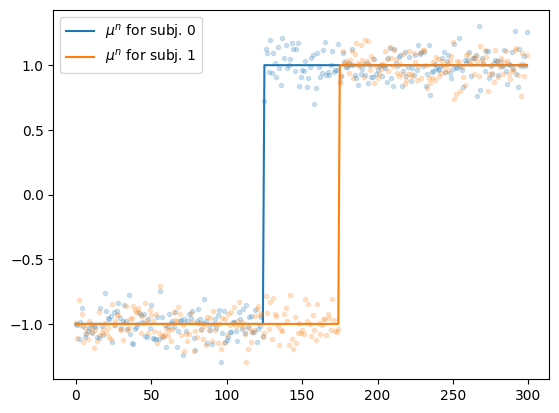

In [6]:
# Sample observations for each subject
this_key, key = jr.split(key)
_sample_one_obs = lambda key: tfd.Normal(true_subj_means, jnp.sqrt(sigmasq_obs)).sample(seed=key)

_, subj_obs = vmap(_sample_one_obs)(jr.split(this_key, num_subjects))

for i in range(2):
    l = plt.plot(true_subj_means[i], alpha=1, label=f'$\mu^n$ for subj. {i}')[0]
    plt.plot(subj_obs[i], '.', color=l.get_color(), alpha=0.2)
plt.legend()

## Sample subject means, holding global means fixed

In [7]:
key = jr.PRNGKey(0)
init_global_means = jnp.average(subj_obs, axis=0)
subj_means = gibbs_sample_subject_means(
    key, subj_obs, sigmasq_obs, init_global_means, sigmasq_subj, mu_pri, sigmasq_pri, hazard_rates)

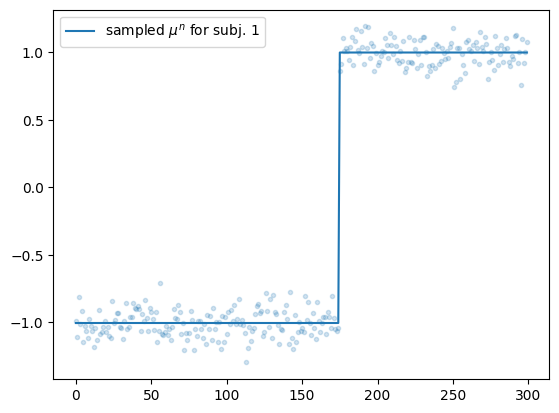

In [8]:
for i in range(1, 2):
    l = plt.plot(subj_means[i], alpha=1, label=f'sampled $\mu^n$ for subj. {i}')[0]
    plt.plot(subj_obs[i], '.', color=l.get_color(), alpha=0.2)
plt.legend()

## Sample global means, holding subject means fixed

In [9]:
from bayes_ca.prox_grad import pgd, pgd_jaxopt

true_global_means = jnp.concatenate((
    -1 * jnp.ones((150, num_features)),
    jnp.ones((150, num_features))
))
x0 = true_global_means
# x0 = jnp.average(true_subj_means, axis=0)

# res = pgd_jaxopt(x0, true_subj_means, mu_pri, sigmasq_pri, sigmasq_subj, hazard_rates, jit=True)
# plt.plot(res.params)

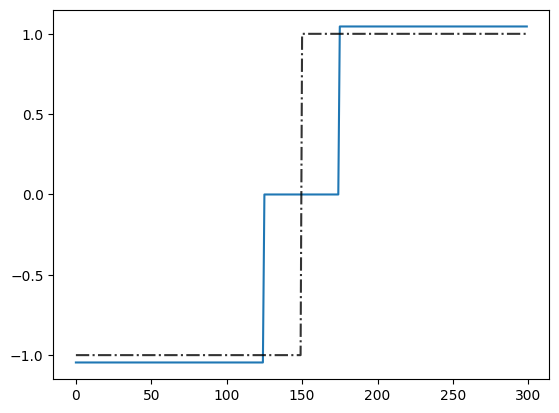

In [10]:
result = pgd(x0, true_subj_means, mu_pri, sigmasq_pri, sigmasq_subj, hazard_rates)
plt.plot(result.x)
# plt.plot(true_subj_means[0])
plt.plot(x0, c='black', ls='-.', alpha=0.8)


In [11]:
print("change in estimated mu_0 over training is :", jnp.sum((result.x - x0)**2) / 2)

print()
print(f"init lognorm : {result.init_lognorm:0.3f}")
print(f"lognorm : {result.lognorm:0.3f}")
print("2x change in log norm over training is :", 2 * (result.lognorm - result.init_lognorm))

print()
print(f"init loss : {result.init_loss:0.3f}")
print(f"loss : {result.loss:0.3f}")
print("change in loss over training is :", result.loss - result.init_loss)


change in estimated mu_0 over training is : 25.26151

init lognorm : -410.195
lognorm : -413.599
2x change in log norm over training is : -6.8078613

init loss : -775.946
loss : -804.743
change in loss over training is : -28.797668


In [12]:
jaxopt = False

sigmasq_pri = 3.0**2
sigmasq_subj = 2.5**2
sigmasq_pri = _safe_handling_params(sigmasq_pri, num_features)
sigmasq_subj = _safe_handling_params(sigmasq_subj, num_features)

# temporal params
num_states = num_timesteps
max_duration = num_states + 1
hazard_prob = 0.01
hazard_rates = hazard_prob * jnp.ones(max_duration)
hazard_rates = hazard_rates.at[-1].set(1.0)

x0 = jnp.average(true_subj_means, axis=0)
# x0 = 0.5 * jr.normal(jr.PRNGKey(0), (num_timesteps, num_features))
# x0 = jnp.zeros((num_timesteps, num_features))
# x0 = true_global_means

result = pgd(x0, true_subj_means, mu_pri, sigmasq_pri, sigmasq_subj, hazard_rates)
est_global_means = (result.x)

print("change in estimated mu_0 over training is :", jnp.sum((result.x - x0)**2) / 2)

print()
print(f"init lognorm : {result.init_lognorm:0.3f}")
print(f"lognorm : {result.lognorm:0.3f}")
print("2x change in log norm over training is :", 2 * (result.lognorm - result.init_lognorm))

print()
print(f"init loss : {result.init_loss:0.3f}")
print(f"loss : {result.loss:0.3f}")
print("change in loss over training is :", result.loss - result.init_loss)

change in estimated mu_0 over training is : 2.3508623

init lognorm : -561.805
lognorm : -562.579
2x change in log norm over training is : -1.5474854

init loss : -1115.610
loss : -1116.405
change in loss over training is : -0.795166


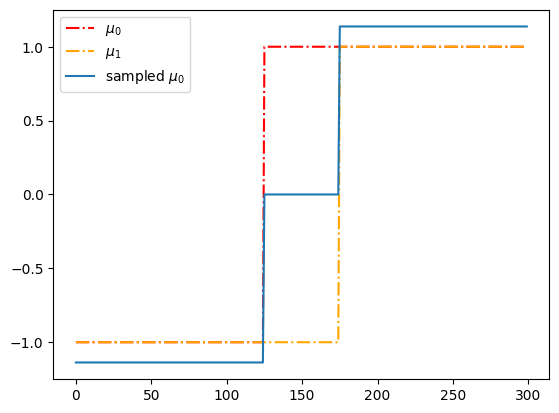

In [13]:
fig = plt.figure()
ax = plt.subplot(111)

ax.plot(true_subj_means[0], ls='-.', label='$\mu_0$', c='red')
ax.plot(true_subj_means[1], ls='-.', label='$\mu_1$', c='orange')
ax.plot(est_global_means, label='sampled $\mu_0$')
plt.legend()

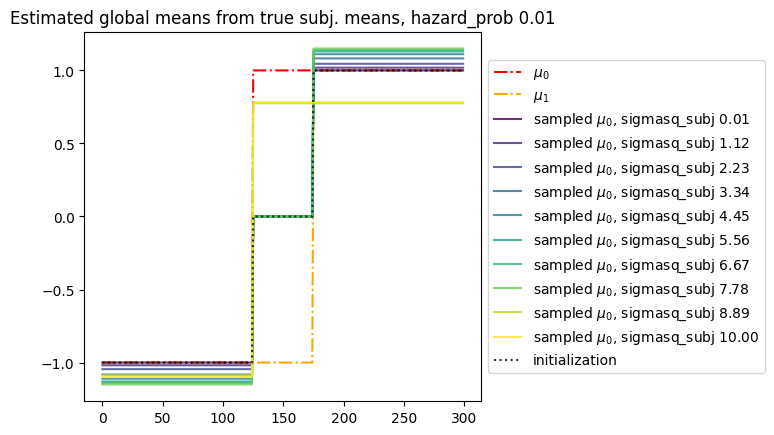

In [14]:
jaxopt = True
sigmasq_subjs = jnp.linspace(0.01, 10.0, 10)

est_global_means = []
for sigmasq_subj in sigmasq_subjs:
    sigmasq_subj = _safe_handling_params(sigmasq_subj, num_features)

    if jaxopt:
        res = pgd_jaxopt(x0, true_subj_means, mu_pri, sigmasq_pri, sigmasq_subj, hazard_rates, jit=True)
        est_global_means.append(res.params)
    else:
        s_res, _, _ = pgd(x0, true_subj_means, mu_pri, sigmasq_pri, sigmasq_subj, hazard_rates)
        est_global_means.append(s_res.x)

fig = plt.figure()
ax = plt.subplot(111)
colors = plt.cm.viridis(jnp.linspace(0, 1, 10))

ax.plot(true_subj_means[0], ls='-.', label='$\mu_0$', c='red')
ax.plot(true_subj_means[1], ls='-.', label='$\mu_1$', c='orange')
for i, (e, s) in enumerate(zip(est_global_means, sigmasq_subjs)):
    ax.plot(e, label=f'sampled $\mu_0$, sigmasq_subj {s:.2f}', c=colors[i], alpha=0.8)
ax.plot(x0, color='k', ls=':', label='initialization', alpha=0.8)
#  sigmasq_subj : {jnp.sqrt(sigmasq_subj)}$^2$
plt.title(f'Estimated global means from true subj. means, hazard_prob {hazard_prob}')
plt.legend()

# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

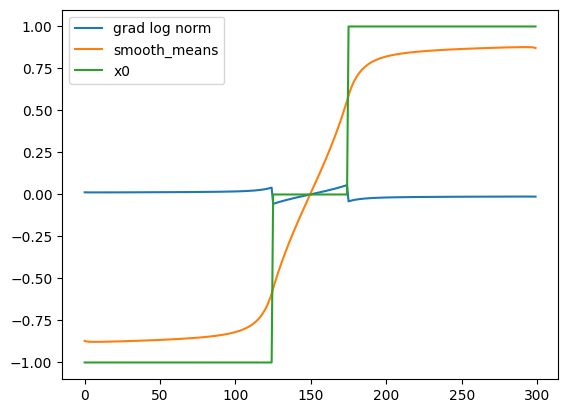

In [15]:
from jax import grad

_, _, _, smooth_means = core.gaussian_cp_smoother(
x0, hazard_rates, mu_pri, sigmasq_pri, sigmasq_subj
)

def log_norm(x):
    log_normalizer, _, _, _ = core.gaussian_cp_smoother(
    x, hazard_rates, mu_pri, sigmasq_pri, sigmasq_subj
    )
    return log_normalizer


g = grad(log_norm)(x0)
plt.plot(g, label='grad log norm')
plt.plot(smooth_means, label='smooth_means')
plt.plot(x0, label='x0')
plt.legend()

## Alternate sampling subject and global means

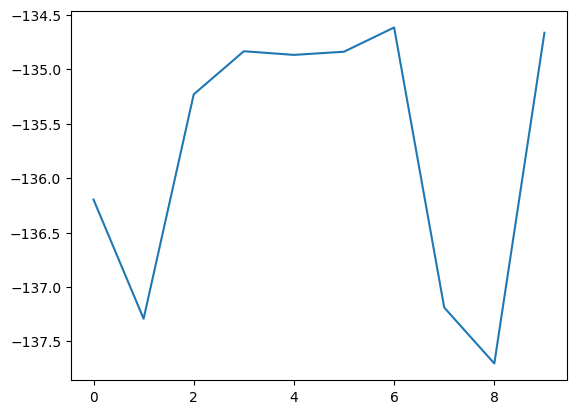

In [16]:
key = jr.PRNGKey(0)
# global_means = jnp.average(subj_obs, axis=0)
global_means = jnp.zeros((num_timesteps, num_features))

lps = []
for itr in progress_bar(range(10)):
    this_key, key = jr.split(key)
    global_means, subj_means, llkhd = step(
        this_key,
        subj_obs, 
        sigmasq_obs, 
        global_means, 
        sigmasq_subj, 
        mu_pri, 
        sigmasq_pri, 
        hazard_rates
    )
    lps.append(llkhd)
plt.plot(lps)

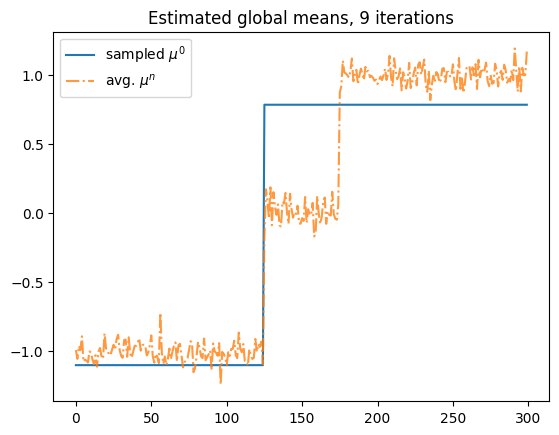

In [17]:
# plt.plot(true_global_means, label='true $\mu_0$')
plt.plot(global_means, label='sampled $\mu^0$')
plt.plot(jnp.average(subj_obs, axis=0), ls='-.', label='avg. $\mu^n$', alpha=0.8)
plt.title(f'Estimated global means, {itr} iterations')
plt.legend()

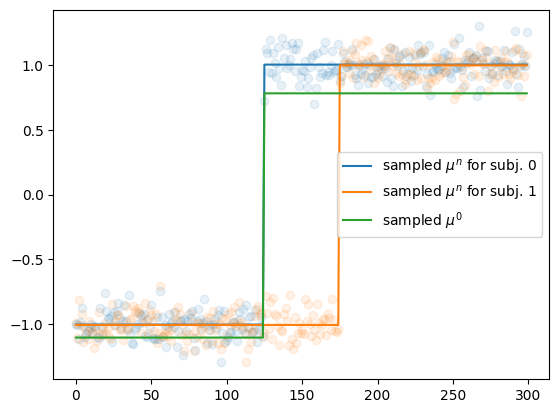

In [18]:
for s in range(2):
    l = plt.plot(subj_means[s], label=f'sampled $\mu^n$ for subj. {s}')[0]
    plt.plot(subj_obs[s], 'o', color=l.get_color(), alpha=0.1, lw=3)
plt.plot(global_means, label='sampled $\mu^0$')
plt.legend()

# Simulation 2. Three subjects, partially overlapping changepoints.

In [19]:
key = jr.PRNGKey(0)

# data settings
num_subjects = 3

# Noisy regime
sigmasq_obs = 0.25**2
sigmasq_obs = _safe_handling_params(sigmasq_obs, num_features)

## Set true global, subject means

Now, we have a slightly more complicated case, where Subject one and Subject two share one changepoint at 100 timesteps.
Their second changepoint, however, is jittered, occuring at 240 timesteps for Subject one and 200 timesteps for Subject two.
We introduce a third subject which has only one changepoint at 240 timesteps, overlapping with Subject one's second changepoint.

In [20]:
this_key, key = jr.split(key)
signal_one = jnp.concatenate(
    (
        jnp.ones((100, 1)) * -0.40,
        jnp.ones((140, 1)) * 0.30,
        jnp.ones((60, 1)) * 0.80,
    )
)
obs_one = tfd.Normal(signal_one, jnp.sqrt(sigmasq_obs)).sample(seed=key)

this_key, key = jr.split(key)
signal_two = jnp.concatenate(
    (
        jnp.ones((100, 1)) * -0.40,
        jnp.ones((100, 1)) * 0.30,
        jnp.ones((100, 1)) * 0.80,
    )
)
obs_two = tfd.Normal(signal_two, jnp.sqrt(sigmasq_obs)).sample(seed=this_key)

this_key, key = jr.split(key)
signal_three = jnp.concatenate(
    (
        jnp.ones((240, 1)) * -0.05,
        jnp.ones((60, 1)) * 0.80,
    )
)
obs_three = tfd.Normal(signal_three, jnp.sqrt(sigmasq_obs)).sample(seed=key)

In [21]:
signals = jnp.stack((signal_one, signal_two, signal_three), axis=0)
obs = jnp.stack((obs_one, obs_two, obs_three), axis=0)

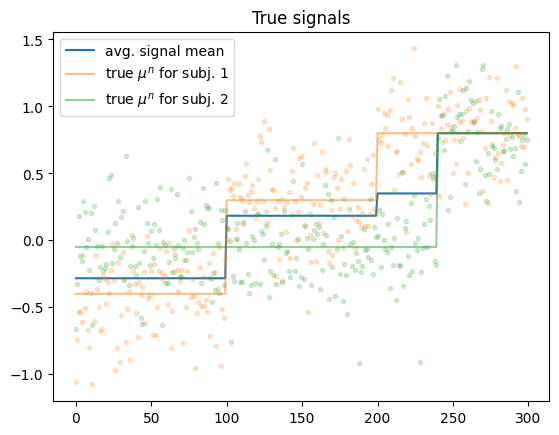

In [22]:
plt.plot(signals.mean(axis=0), label='avg. signal mean')

for i in range(1, 3):
    l = plt.plot(signals[i], alpha=0.5, label=f'true $\mu^n$ for subj. {i}')[0]
    plt.plot(obs[i], '.', color=l.get_color(), alpha=0.2)
plt.title("True signals")
plt.legend()
# plt.xlim(0, 250)

## Sample conditional distribution for each subject, holding the global fixed

The effective observations for each subject are the weighted average of its observations and the global mean.

In [23]:
key = jr.PRNGKey(0)
init_global_means = jnp.mean(obs, axis=0)
subj_means = gibbs_sample_subject_means(
    key, obs, sigmasq_obs, init_global_means, sigmasq_subj, mu_pri, sigmasq_pri, hazard_rates)

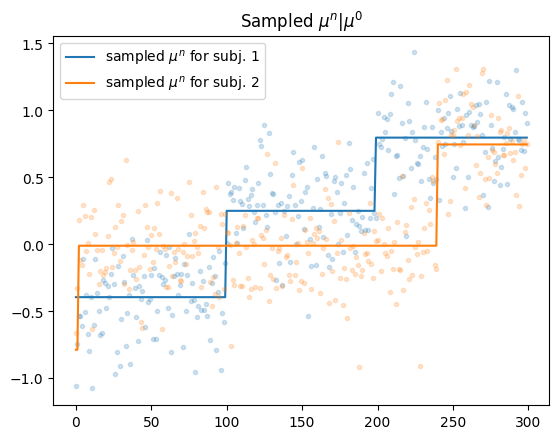

In [24]:
for i in range(1, 3):
    l = plt.plot(subj_means[i], alpha=1, label=f'sampled $\mu^n$ for subj. {i}')[0]
    plt.plot(obs[i], '.', color=l.get_color(), alpha=0.2)
plt.title("Sampled $\mu^n | \mu^0$")
plt.legend()

## Sample global mean, holding subject means fixed

In [25]:
x0 = jnp.mean(obs, axis=0)

result = pgd(x0, subj_means, mu_pri, sigmasq_pri, sigmasq_subj, hazard_rates)
global_means = result.x

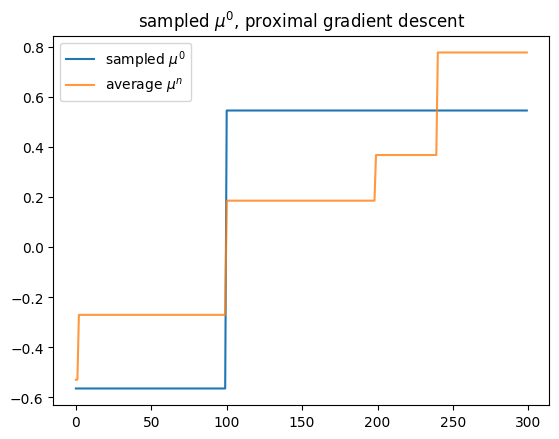

In [26]:
plt.plot(global_means, label='sampled $\mu^0$')
plt.plot(jnp.average(subj_means, axis=0), label='average $\mu^n$', alpha=0.8)
# plt.plot(g, label='gradient', ls='-.', alpha=0.8)
plt.title(f'sampled $\mu^0$, proximal gradient descent')
plt.legend()

## Alternate sampling subject and global means.

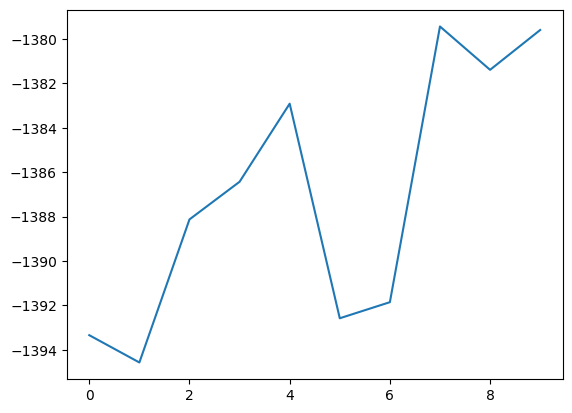

In [27]:
key = jr.PRNGKey(0)
# global_means = jnp.mean(obs, axis=0)
global_means = jnp.zeros((num_timesteps, num_features))

lps = []
for itr in progress_bar(range(10)):
    this_key, key = jr.split(key)
    global_means, subj_means, train_lp = step(
        this_key,
        obs, 
        sigmasq_obs, 
        global_means, 
        sigmasq_subj, 
        mu_pri, 
        sigmasq_pri, 
        hazard_rates
    )
    lps.append(train_lp)

plt.plot(lps)

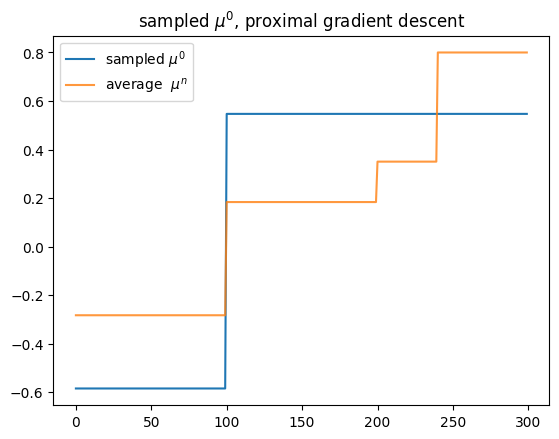

In [28]:
plt.plot(global_means, label='sampled $\mu^0$')
plt.plot(signals.mean(axis=0), label='average  $\mu^n$', alpha=0.8)
plt.title(f'sampled $\mu^0$, proximal gradient descent')
plt.legend()

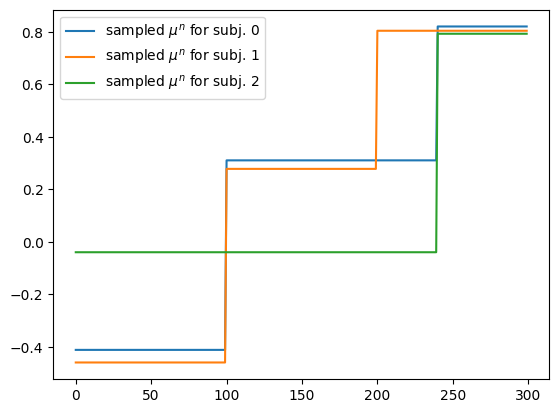

In [29]:
for i in range(3):
    l = plt.plot(subj_means[i], label=f'sampled $\mu^n$ for subj. {i}')[0]
    # plt.plot(obs[i], '.', color=l.get_color(), alpha=0.2)
# plt.plot(global_means, label='sampled $\mu^0$')
plt.legend()

## Examine transition probabilities

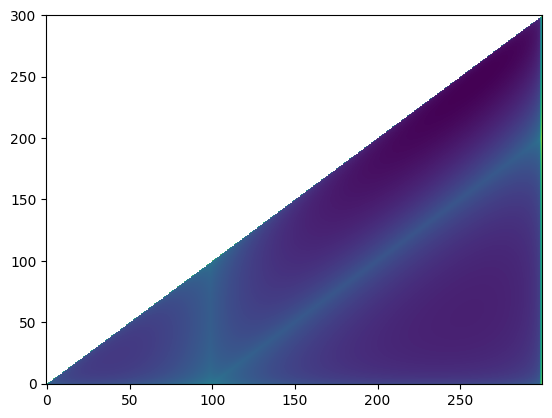

In [30]:
log_normalizer, smoothed_probs, transition_probs, expected_subj_means = core.gaussian_cp_smoother(
    global_means, hazard_rates, mu_pri, sigmasq_pri, sigmasq_subj)
plt.imshow(jnp.log(transition_probs.T), aspect='auto', origin='lower')

# Simulation 3. Learning from noise.

So far, we have passed structured data; i.e., where there is at least one true changepoint.
Next we can check what happens if we pass random noise.
We'll want to compare this against varying hazard probabilities.

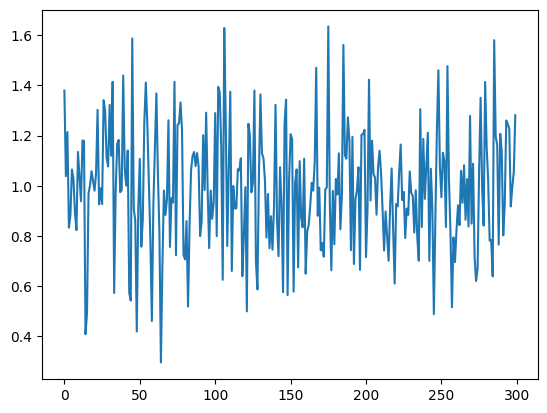

In [31]:
key = jr.PRNGKey(0)
this_key, key = jr.split(key)

_sample_noise = lambda key: tfd.Normal(
    jnp.ones((num_timesteps, num_features)),
    jnp.sqrt(sigmasq_obs)).sample(seed=key)
all_obs = vmap(_sample_noise)(jr.split(this_key, num_subjects + 1))  # incl. global
global_means = all_obs[0]
subj_obs = all_obs[1:]

plt.plot(global_means)

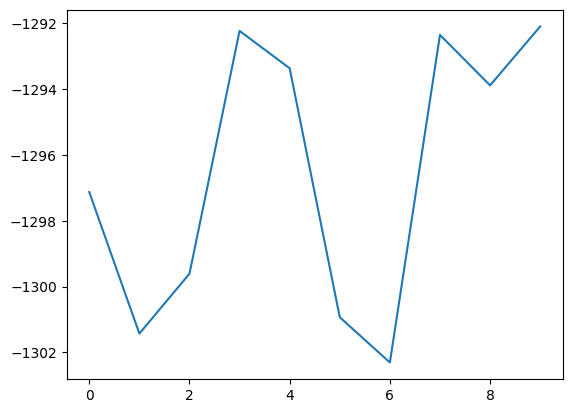

In [32]:
key = jr.PRNGKey(0)
# global_means = jnp.average(subj_obs, axis=0)

lps = []
for itr in progress_bar(range(10)):
    this_key, key = jr.split(key)
    global_means, subj_means, train_lp = step(
        this_key,
        subj_obs, 
        sigmasq_obs, 
        global_means, 
        sigmasq_subj, 
        mu_pri, 
        sigmasq_pri, 
        hazard_rates
    )
    lps.append(train_lp)
plt.plot(lps)

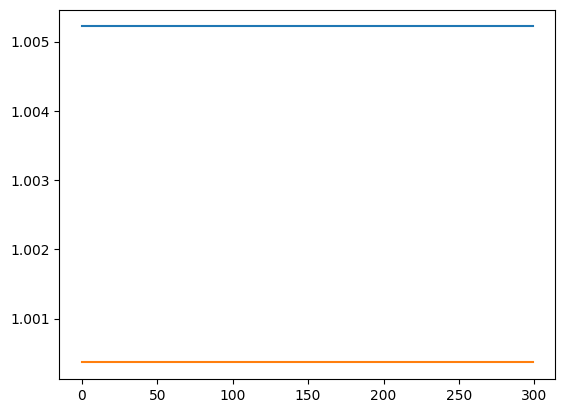

In [33]:
plt.plot(global_means, label='sampled $\mu^0$')
plt.plot(subj_means[0], label=f'sampled $\mu^n$ for subj. 0')

# Simulation 4. Unstructured simulation.

Finally, we look at a relatively unstructured simulation, in which we sample a large-ish number of subject means off of a fixed global mean.
We do not constrain the precise timing of any individual subject changepoints.

In [34]:
key = jr.PRNGKey(0)

# top level params
num_subjects = 5
num_features = 1
num_timesteps = 500

mu_pri = 0.0
sigmasq_pri = 3.0**2
sigmasq_subj = 1.5**2
sigmasq_obs = 0.1**2

mu_pri = _safe_handling_params(mu_pri, num_features)
sigmasq_pri = _safe_handling_params(sigmasq_pri, num_features)
sigmasq_subj = _safe_handling_params(sigmasq_subj, num_features)
sigmasq_obs = _safe_handling_params(sigmasq_obs, num_features)

# temporal params
num_states = 100
max_duration = num_states + 1
hazard_prob = 0.01

hazard_rates = hazard_prob * jnp.ones(max_duration)
hazard_rates = hazard_rates.at[-1].set(1.0)

In [35]:
# First sample the global states
this_key, key = jr.split(key)
_, true_global_means = core.sample_gaussian_cp_model(key, num_timesteps, hazard_rates, mu_pri, sigmasq_pri)

# Sample means for each subject given the global mean
this_key, key = jr.split(key)
_sample_one = lambda key: core.gaussian_cp_posterior_sample(
    key, true_global_means, hazard_rates, mu_pri, sigmasq_pri, sigmasq_subj)

_, true_subj_means = vmap(_sample_one)(jr.split(this_key, num_subjects))

# Finally, sample observations for each subject
this_key, key = jr.split(key)
subj_obs = tfd.Normal(true_subj_means, jnp.sqrt(sigmasq_obs)).sample(seed=this_key)

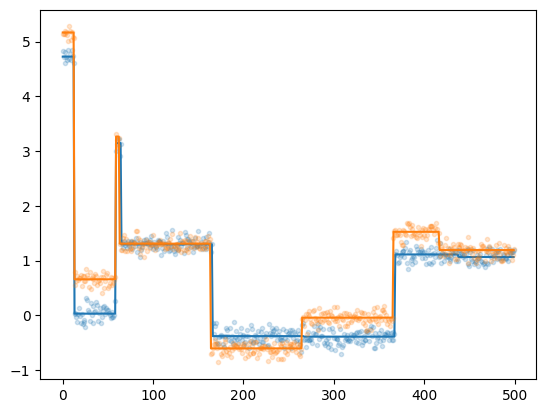

In [36]:
# plt.plot(true_global_means, '-k', lw=3)

for i in range(2):
    l = plt.plot(true_subj_means[i][:, 0], alpha=1)[0]
    plt.plot(subj_obs[i][:, 0], '.', color=l.get_color(), alpha=0.2)
# plt.xlim(0, 250)

## Sample subject means, holding global means constant

In [37]:
key = jr.PRNGKey(0)
subj_means = gibbs_sample_subject_means(
    key, subj_obs, sigmasq_obs, true_global_means, sigmasq_subj, mu_pri, sigmasq_pri, hazard_rates)

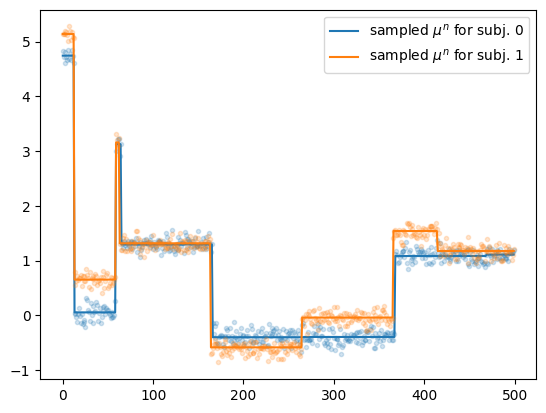

In [38]:
for i in range(2):
    l = plt.plot(subj_means[i][:, 0], alpha=1, label=f'sampled $\mu^n$ for subj. {i}')[0]
    plt.plot(subj_obs[i][:, 0], '.', color=l.get_color(), alpha=0.2)
plt.legend()

## Sample global means, holding subject means constant

In [41]:
from bayes_ca.prox_grad import pgd

# x0 = jnp.average(subj_obs, axis=0)
# x0 = 0.5 * jr.normal(jr.PRNGKey(0), (num_timesteps, num_features))
x0 = jnp.zeros((num_timesteps, num_features))

result = pgd(x0, subj_means, mu_pri, sigmasq_pri, sigmasq_subj, hazard_rates)
est_global_means = result.x

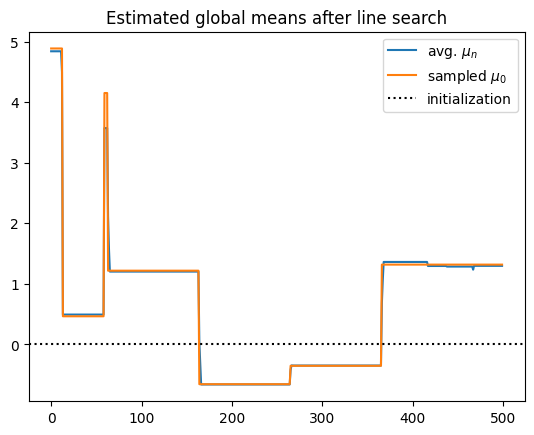

In [42]:
plt.plot(true_subj_means.mean(axis=0)[:, 0], label='avg. $\mu_n$')
plt.plot(est_global_means[:, 0], label='sampled $\mu_0$')
# plt.plot(g, ls='-.', label='gradient', alpha=0.8)
plt.axhline(0.0, color='k', ls=':', label='initialization')
plt.title(f'Estimated global means after line search')
plt.legend()

## Alternate sampling subject and global means

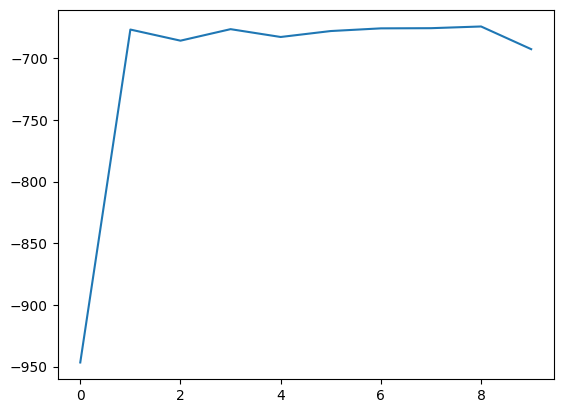

In [43]:
key = jr.PRNGKey(0)
# global_means = jnp.average(subj_obs, axis=0)
global_means = jnp.ones((num_timesteps, num_features)) * -10

lps = []
for itr in progress_bar(range(10)):
    this_key, key = jr.split(key)
    global_means, subj_means, train_lp = step(
        this_key,
        subj_obs, 
        sigmasq_obs, 
        global_means, 
        sigmasq_subj, 
        mu_pri, 
        sigmasq_pri, 
        hazard_rates
    )
    lps.append(train_lp)

plt.plot(lps)

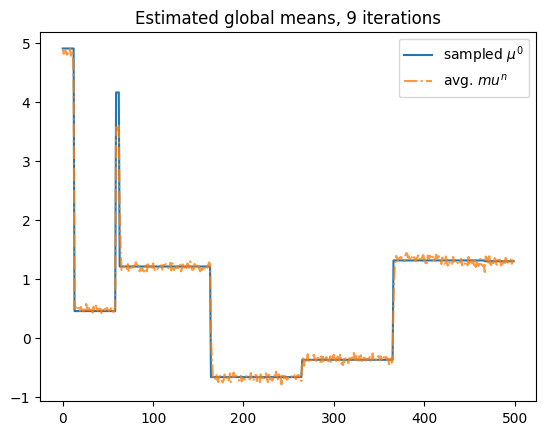

In [44]:
# plt.plot(true_global_means, label='true $\mu_0$')
plt.plot(global_means, label='sampled $\mu^0$')
plt.plot(jnp.average(subj_obs, axis=0), ls='-.', label='avg. $mu^n$', alpha=0.8)
plt.title(f'Estimated global means, {itr} iterations')
plt.legend()

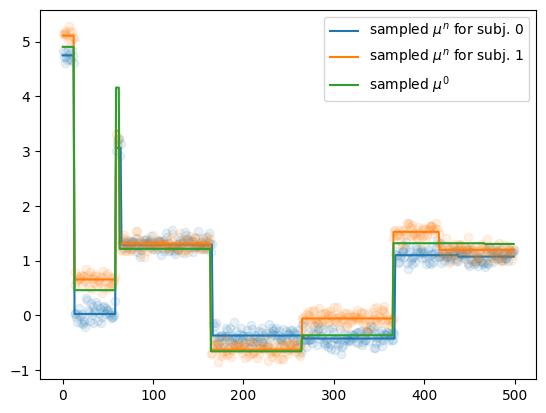

In [45]:
for s in range(2):
    l = plt.plot(subj_means[s], label=f'sampled $\mu^n$ for subj. {s}')[0]
    plt.plot(subj_obs[s], 'o', color=l.get_color(), alpha=0.1, lw=3)
plt.plot(global_means, label='sampled $\mu^0$')
plt.legend()